In [1]:
from src.modeling.cnn_vae import CNN_VAE
from src.data.df_dataset import DfDataset
from src.analysis import correlation_with_fitness
from src.factors import mutated_amino_acids

from pathlib import Path

import torch.nn.functional as F
from matplotlib import rcParams
from torch.optim import Adam
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.cluster import KMeans, DBSCAN

In [2]:
model = CNN_VAE.load_from_checkpoint(  
    "/Users/tobiaochsner/Documents/ETH/GeneticFitness/data/models/cnn_vae_synonymous_batches/epoch=43-val_loss=0.34.ckpt"
)

In [3]:
df = pd.read_csv("/Users/tobiaochsner/Documents/ETH/GeneticFitness/data/output_history/cnn_vae_synonymous_batches_2023_11_08_15_56_26/preprocessed.csv")
df = df[df["fitness"] == df["fitness"]]

In [4]:
# add mutated aa
df = mutated_amino_acids(df)

In [5]:
# make predictions
dataset = DfDataset(df, ["rna_loops", "sequence_dna"])
loader = DataLoader(dataset, batch_size=len(dataset))

all_items = next(iter(loader))
predictions = model(all_items)

predictions = model(all_items)
predictions = predictions[2].detach().numpy()

for i in range(predictions.shape[1]):
    df[f"prediction_{i}"] = predictions[:, i]

In [6]:
# add correlation
correlation_with_fitness(
    df, Path(),
    [
        "prediction_0",
        "prediction_1",
        "prediction_2",
        "prediction_3",
        "prediction_4",
    ],
    ["mutated_amino_acids"]
)
correlation_df = pd.read_csv("correlation.csv")

/Users/tobiaochsner/Documents/ETH/GeneticFitness/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/tobiaochsner/Documents/ETH/GeneticFitness/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/tobiaochsner/Documents/ETH/GeneticFitness/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/tobiaochsner/Documents/ETH/GeneticFitness/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  

<Figure size 640x480 with 0 Axes>

In [7]:
# add normalized fitness
df["normalized_fitness"] = df.apply(lambda row: row["fitness"] - df[df["mutated_amino_acids"] == row["mutated_amino_acids"]]["fitness"].mean(), axis=1)

In [8]:
# add mutated sequence and number of sequences per aa group to correlation df
correlation_df["aa"] = correlation_df["Unnamed: 0"].map(lambda x: x.replace("(", "").replace(")", "").replace("'", "").replace(",", ""))
correlation_df["num_sequences"] = correlation_df["aa"].map(lambda x: len(df[df["mutated_amino_acids"] == x]))

### Look at significant correlations

In [73]:
significant_groups = correlation_df[(correlation_df["prediction_3_correlation_p_value"] < 0.05)]
len(significant_groups)

209

/Users/tobiaochsner/Documents/ETH/GeneticFitness/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tobiaochsner/Documents/ETH/GeneticFitness/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='prediction_3', ylabel='normalized_fitness'>

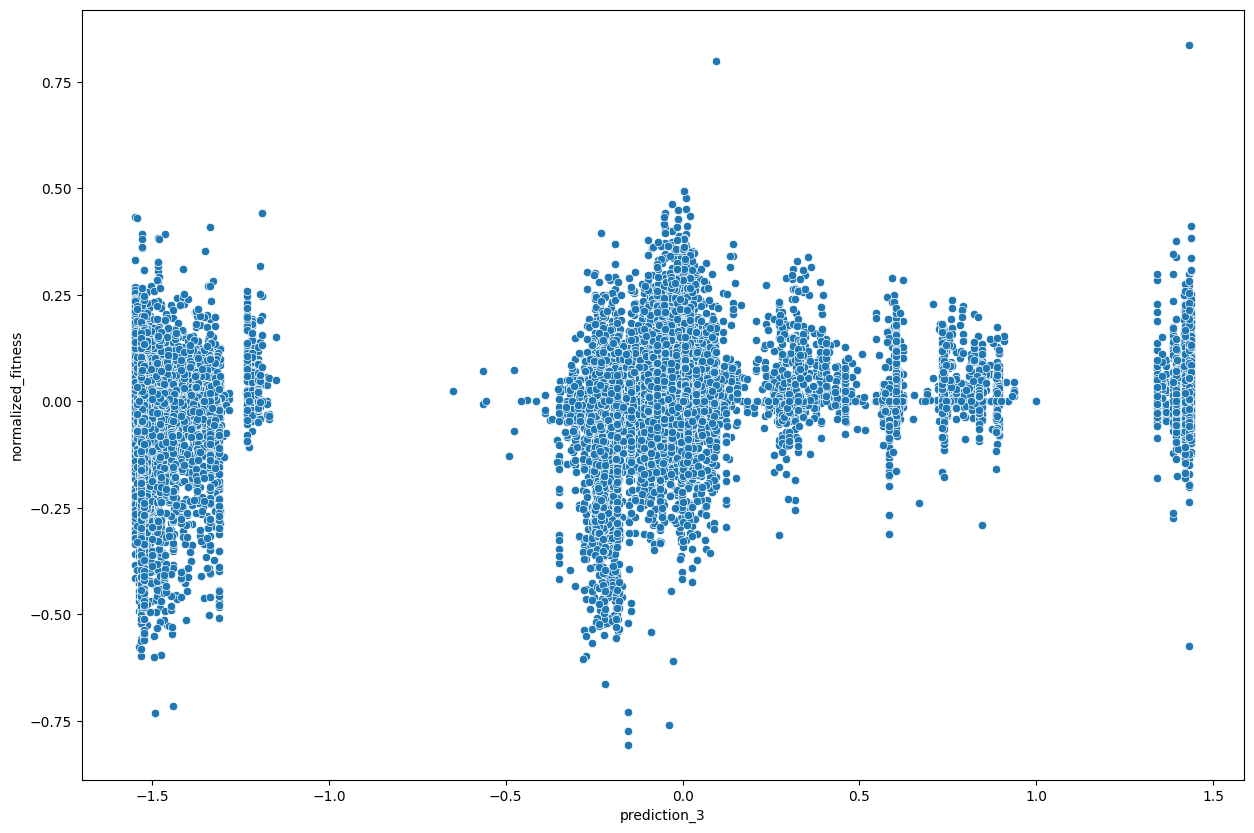

In [90]:
sns.scatterplot(x="prediction_3", y="normalized_fitness", data=df)

In [74]:
significant_samples = df[df["mutated_amino_acids"].isin(significant_groups["aa"].tolist())]
len(significant_samples), len(df), len(significant_samples) / len(df)

(5568, 18039, 0.3086645601197406)

/Users/tobiaochsner/Documents/ETH/GeneticFitness/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tobiaochsner/Documents/ETH/GeneticFitness/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tobiaochsner/Documents/ETH/GeneticFitness/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='prediction_2', ylabel='prediction_3'>

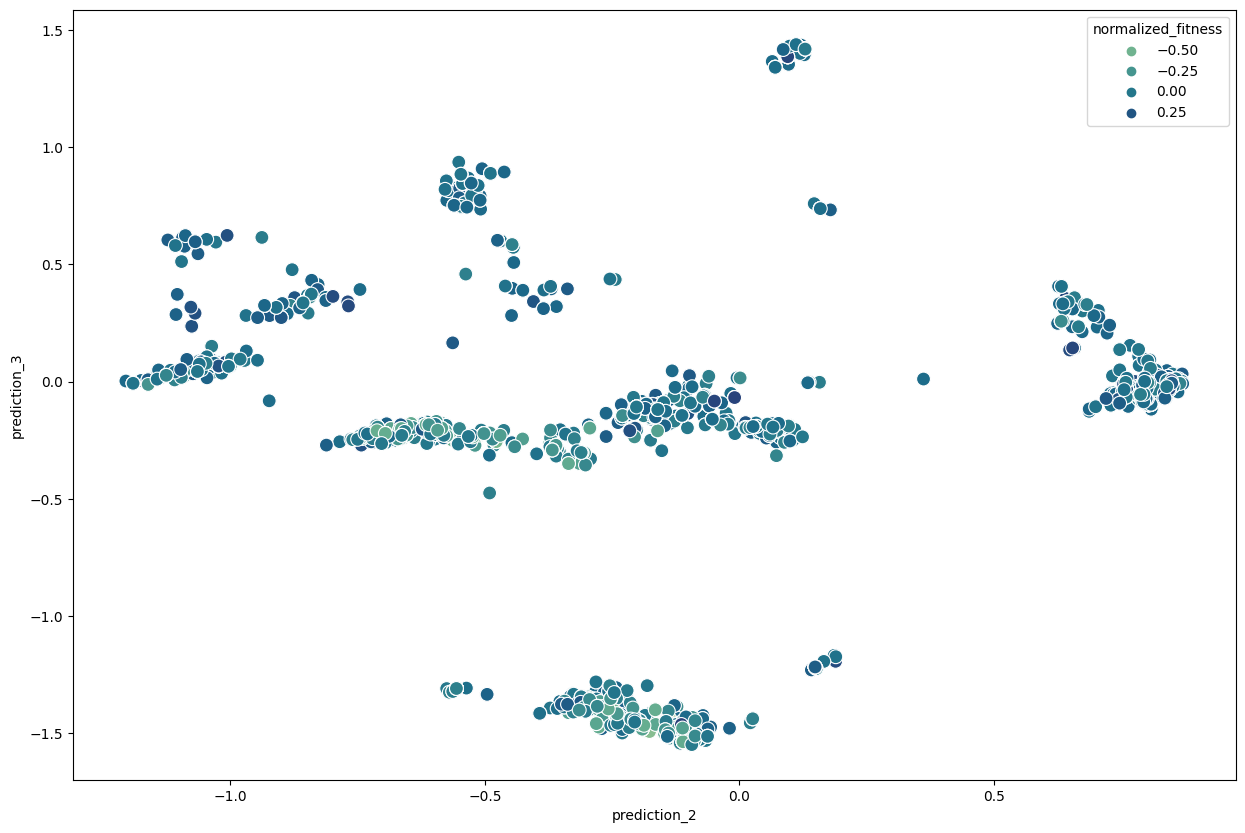

In [75]:
rcParams['figure.figsize'] = 15, 10
sns.scatterplot(x="prediction_2", y="prediction_3", data=significant_samples.sample(frac=1), hue="normalized_fitness", palette="crest", s=100,)

### Clustering

In [76]:
kmeans = KMeans(n_clusters=2, random_state=0)
significant_samples["cluster"] = kmeans.fit_predict(significant_samples[["prediction_0", "prediction_1", "prediction_2", "prediction_3", "prediction_4"]])

/Users/tobiaochsner/Documents/ETH/GeneticFitness/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/f_/r0jt4c1153v7d286lm9gbgx80000gn/T/ipykernel_82893/3284233135.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  significant_samples["cluster"] = kmeans.fit_predict(significant_samples[["prediction_0", "prediction_1", "prediction_2", "prediction_3", "prediction_4"]])


/Users/tobiaochsner/Documents/ETH/GeneticFitness/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tobiaochsner/Documents/ETH/GeneticFitness/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tobiaochsner/Documents/ETH/GeneticFitness/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tobiaochsner/Documents/ETH/GeneticFitness/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498:

<Axes: xlabel='prediction_2', ylabel='prediction_3'>

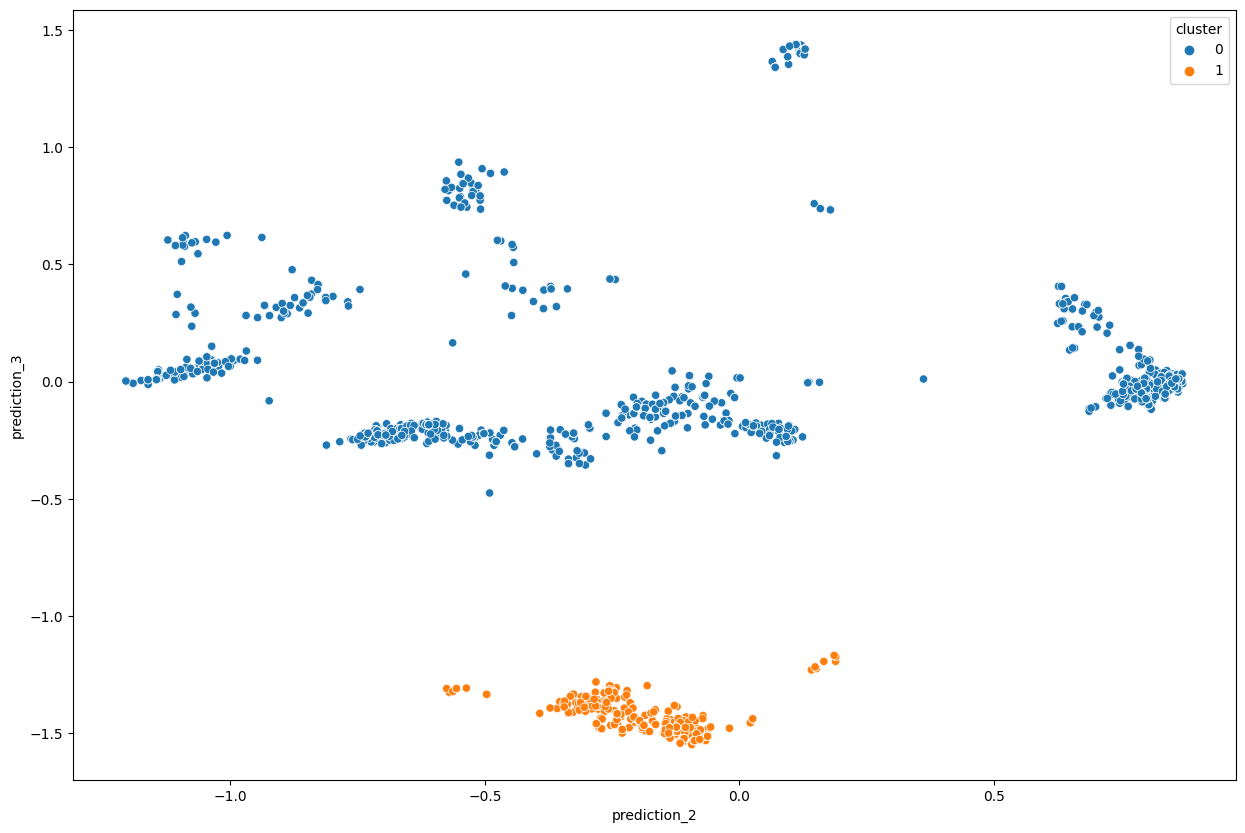

In [77]:
sns.scatterplot(x="prediction_2", y="prediction_3", data=significant_samples, hue="cluster")

In [78]:
significant_samples.sort_values(["mutated_amino_acids", "fitness"]).to_csv("significant_samples.csv")

In [79]:
significant_samples.groupby("cluster")[["fitness", "normalized_fitness"]].mean()

,fitness,normalized_fitness
cluster,,
0,0.383952,0.034935
1,0.282758,-0.094572


/Users/tobiaochsner/Documents/ETH/GeneticFitness/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tobiaochsner/Documents/ETH/GeneticFitness/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/tobiaochsner/Documents/ETH/GeneticFitness/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tobiaochsner/Documents/ETH/GeneticFitness/.venv/lib/python3.11/site-packages/seaborn/_oldcor

<Axes: xlabel='normalized_fitness', ylabel='Density'>

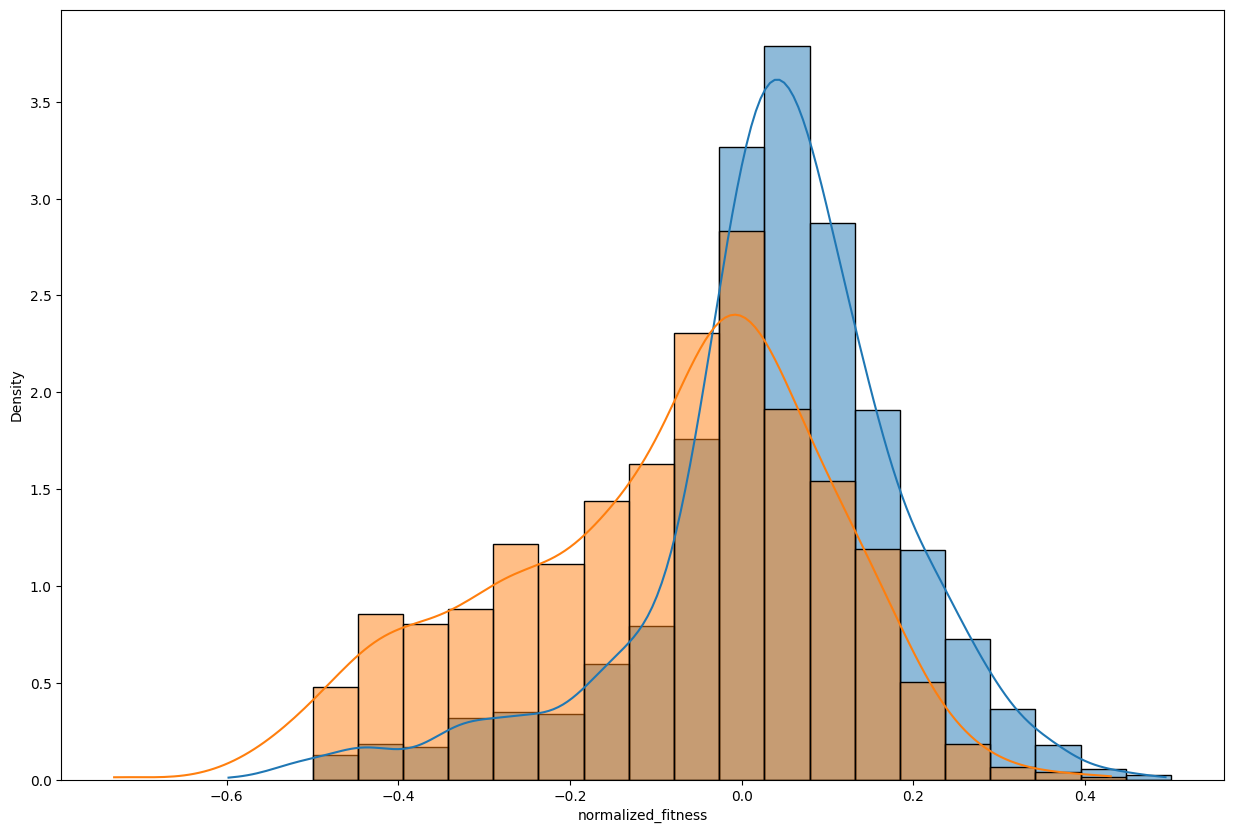

In [80]:
bins = np.linspace(-0.5, 0.5, 20)
sns.histplot(significant_samples[significant_samples["cluster"] == 0], x="normalized_fitness", stat="density", bins=bins, kde=True)
sns.histplot(significant_samples[significant_samples["cluster"] == 1], x="normalized_fitness", stat="density", bins=bins, kde=True)

In [81]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [82]:
lda = LinearDiscriminantAnalysis()

In [83]:
transformed = lda.fit_transform(significant_samples[["prediction_0", "prediction_1", "prediction_2", "prediction_3", "prediction_4"]], significant_samples["cluster"])

In [84]:
significant_samples["transformed"] = transformed

/var/folders/f_/r0jt4c1153v7d286lm9gbgx80000gn/T/ipykernel_82893/1490396882.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  significant_samples["transformed"] = transformed


/Users/tobiaochsner/Documents/ETH/GeneticFitness/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tobiaochsner/Documents/ETH/GeneticFitness/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tobiaochsner/Documents/ETH/GeneticFitness/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tobiaochsner/Documents/ETH/GeneticFitness/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498:

<Axes: xlabel='transformed', ylabel='normalized_fitness'>

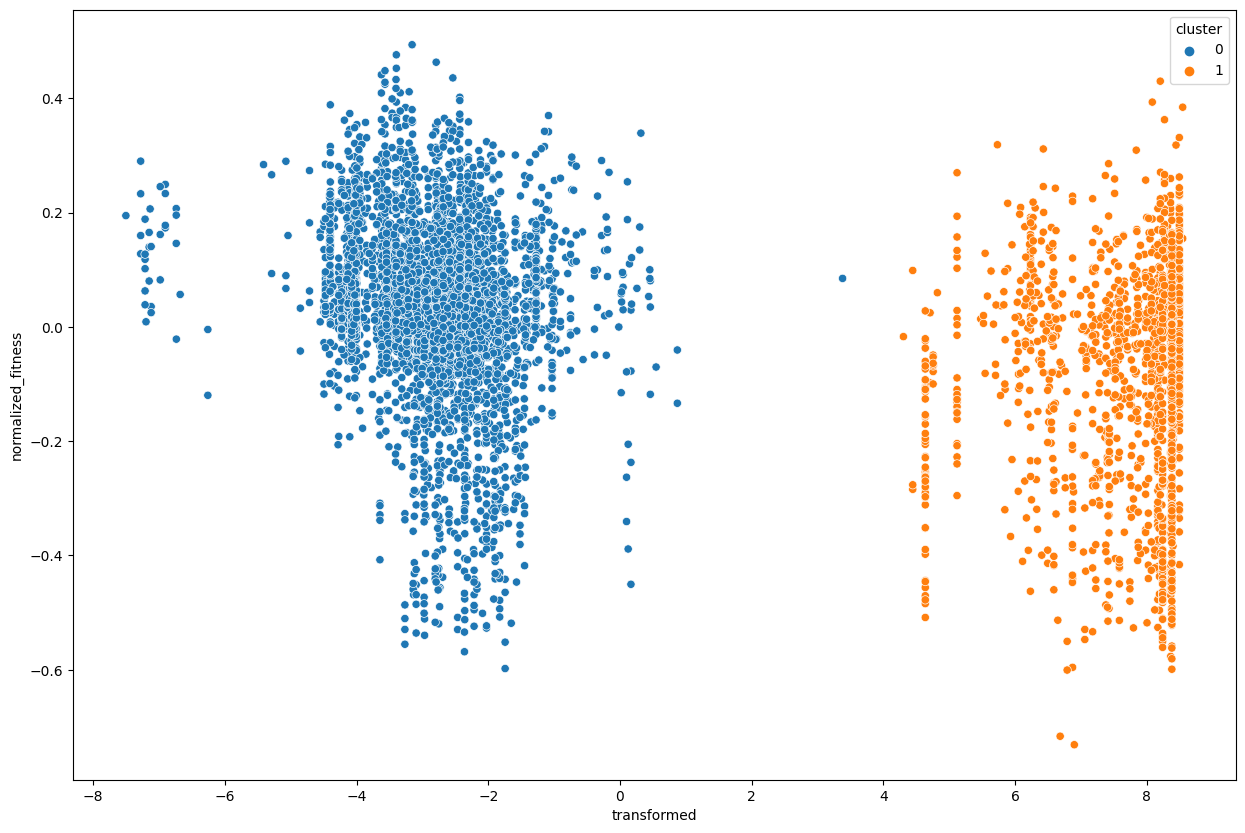

In [85]:
sns.scatterplot(x="transformed", y="normalized_fitness", data=significant_samples, hue="cluster")

In [86]:
significant_samples[["normalized_fitness", "transformed"]].corr()

,normalized_fitness,transformed
normalized_fitness,1.000000,-0.348489
transformed,-0.348489,1.000000
